In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import scipy.spatial.distance
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.tree import DecisionTreeRegressor
import os
import shutil
import glob
import shap
from scipy.stats import pearsonr

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

sd = 0
rstate = sd
np.random.seed(sd)
njob = -1
global_trees = 100

plt.rcParams['axes.grid'] = False

In [4]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns

In [5]:
def compute_carried_shap(s_vals, comps, X):
    shap_values_r = np.arange(0, X.shape[0]).reshape(-1, 1)
    carried_shap_vals = np.apply_along_axis((lambda x : s_vals[x].reshape(-1, 1).T @ comps), 1, shap_values_r).reshape(-1, X.shape[1])
    return carried_shap_vals

def mean_carried_shap(s_vals, comps, X):
    
    sump = np.sqrt(np.mean(comps ** 2, axis=0))
    sump[np.where(sump == 0)[0]] = 1
    sump = sump ** 2
    sump[np.where(sump < 1e-8)[0]] = 1
    
    t = compute_carried_shap(s_vals, comps, X) / sump
    return np.mean(np.abs(t), axis=0) 

In [6]:
rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X, Y)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X, approximate=True)
ov_shap = np.mean(np.abs(s_vals), axis=0)
ov_shap /= np.max(ov_shap)
ov_shap /= len(ov_shap)

In [7]:
pca = PCA(n_components=50)
pca.fit(X)
# comps = compute_sparse_components(pca.components_, X.shape[1], 0.85)
comps = pca.components_
X_r = (comps @ X.T).T

rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X_r, Y)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X_r, approximate=True)
ov_reduced_shap = mean_carried_shap(s_vals, pca.components_, X)
ov_reduced_shap /= np.max(ov_reduced_shap)
ov_reduced_shap /= len(ov_reduced_shap)

In [6]:
overlaps = []
for i in range(100):

    shapf = np.argsort(ov_shap)[::-1][:i]
    lraf = np.argsort(ov_reduced_shap)[::-1][:i]

    overlap = len(set(shapf).intersection(lraf))

    overlaps.append(overlap)

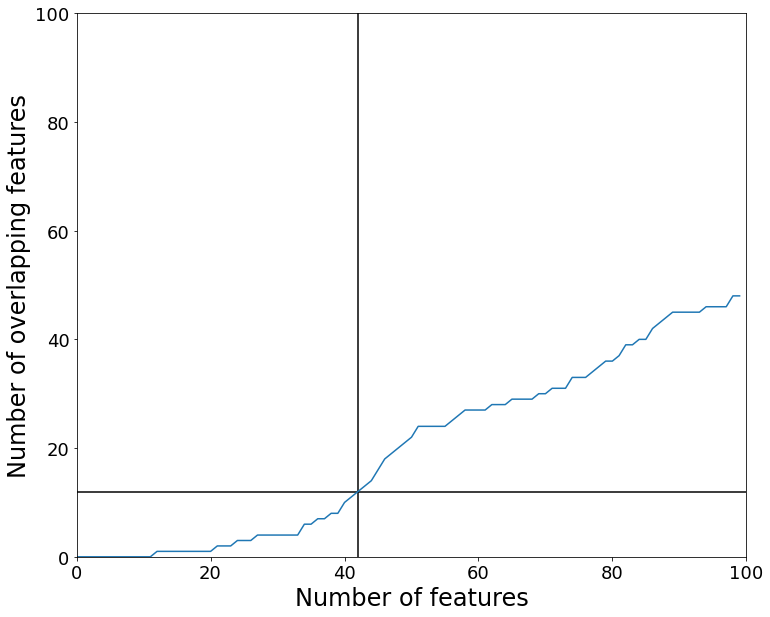

In [7]:
plt.figure(figsize=(12,10))

plt.plot(overlaps)

plt.ylabel("Number of overlapping features", fontsize=24)
plt.xlabel("Number of features", fontsize=24)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim([0,100])
plt.ylim([0,100])

plt.vlines(42,0,100)
plt.hlines(overlaps[42], 0, 100)

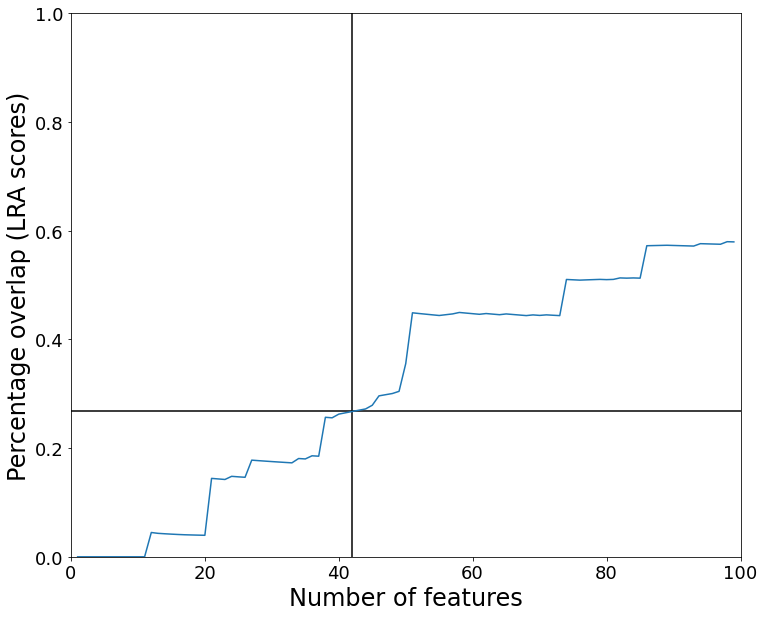

In [8]:
counter = 0
shap_imps_list = []
overlapsi = []
for i in range(100):

    shapf = np.argsort(ov_shap)[::-1][:i]
    lraf = np.argsort(ov_reduced_shap)[::-1][:i]

    overlap = np.sum(ov_reduced_shap[list(set(shapf).intersection(lraf))]) / np.sum(np.sort(ov_reduced_shap)[::-1][:i])
    
    overlapsi.append(overlap)
    
plt.figure(figsize=(12,10))

plt.plot(overlapsi)

plt.ylabel("Percentage overlap (LRA scores)", fontsize=24)
plt.xlabel("Number of features", fontsize=24)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim([0,100])
plt.ylim([0,1])

plt.vlines(42,0,1)
plt.hlines(overlapsi[42], 0, 100)

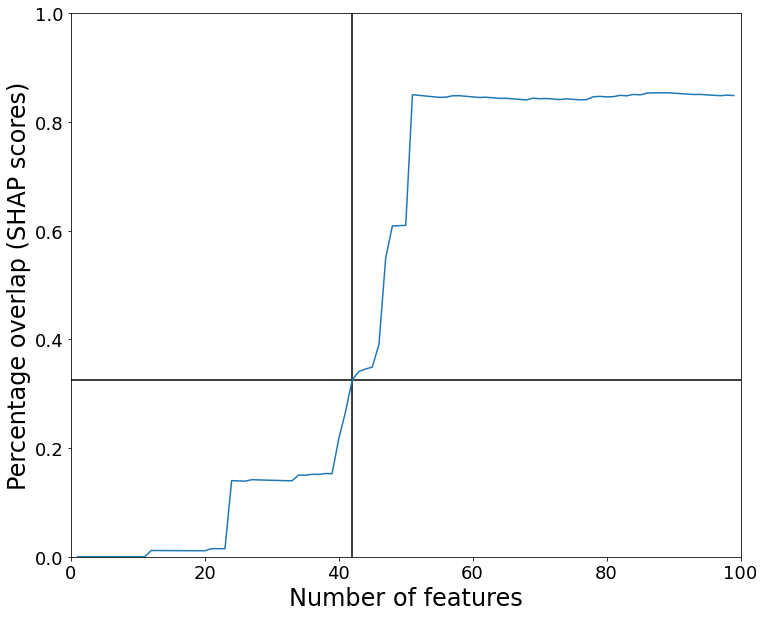

In [9]:
counter = 0
shap_imps_list = []
overlapsi = []
for i in range(100):

    shapf = np.argsort(ov_shap)[::-1][:i]
    lraf = np.argsort(ov_reduced_shap)[::-1][:i]

    overlap = np.sum(ov_shap[list(set(shapf).intersection(lraf))]) / np.sum(np.sort(ov_shap)[::-1][:i])
    
    overlapsi.append(overlap)

plt.figure(figsize=(12,10))

plt.plot(overlapsi)

plt.ylabel("Percentage overlap (SHAP scores)", fontsize=24)
plt.xlabel("Number of features", fontsize=24)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim([0,100])
plt.ylim([0,1])

plt.vlines(42,0,1)
plt.hlines(overlapsi[42], 0, 100)

In [23]:
counter = 0
shap_imps_list = []
overlapsi = []

corl = []

for j in range(0, 10):
    
    correlations = []
    
    s2 = np.argsort(ov_reduced_shap)[::-1][j]
    l2 = pd.DataFrame(X[:,s2])
    
    for i in range(0,  10):

        s1 = np.argsort(ov_shap)[::-1][i]

        l1 = pd.DataFrame(X[:,s1])

        correlations.append(np.corrcoef(l2.values.flatten(), l1.values.flatten())[0,1])
        
    corl.append(correlations)

In [22]:
np.mean(np.abs(correlations))

0.8391254192364415

In [26]:
for i in range(0, 10):
    print(np.mean(np.abs(corl[i])))

0.893522426135404
0.7129976269911155
0.8338930864968048
0.9501831302943022
0.8379602795515938
0.8380086196668257
0.9044198366567391
0.859829600917621
0.7591959047138718
0.3434406417481531


In [28]:
np.mean(np.abs(corl))

0.7933451153172432